# Importing Libraries

In [1]:
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import torch
from tqdm import tqdm
from torch import nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reading Data

In [2]:
ground_truth = pd.read_csv("Data/gtruth_codes_512.tsv", sep="\t")

In [3]:
train_images = []
image_names = []
train_images_path = "Data/BCSS/train"
for i in os.listdir(train_images_path)[:3000]:
    image_names.append(i)
    img = cv2.imread(os.path.join(train_images_path, i))
    train_images.append(img)



In [4]:
mask_images = []

mask_images_path = "Data/BCSS/train_mask"
for i in image_names:
    img = cv2.imread(os.path.join(mask_images_path, i))
    mask_images.append(img)





# Unique Classes and Helper Functions

In [5]:
# Finding Unique Classes
unique_classes = set()
for i in mask_images:
    for j in np.unique(i):
        unique_classes.add(j)

print(unique_classes)

{0, 1, 2}


In [6]:
def preprocess_mask(masks,class_num):
    
    one_hot_masks = []
    for i in range(len(masks)):
        mask = masks[i][:,:,0]
        one_hot_mask = np.zeros((mask.shape[0],mask.shape[1],class_num),dtype=int)
        for i in range(mask.shape[0]):
            for j in range(mask.shape[1]):
                one_hot_mask[i,j,mask[i,j]] = 1
        one_hot_masks.append(one_hot_mask)
       
    return np.array(one_hot_masks)


def prediction_To_mask(pred,class_Num): 

    masks = []
    for img in pred:
        
    
        mask = np.zeros((img.shape[0],img.shape[1],class_Num),dtype=int)
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                mask[i,j,:] = np.argmax(img[i,j,:])
        masks.append(mask)
    return masks

def convert_mask_to_RGB(mask_Exp):
    for i in range(len(mask_Exp)):
        for j in range(len(mask_Exp)):
            if mask_Exp[i][j][0] ==  0 : 
                mask_Exp[i][j] =  [255,0,0] 
            elif mask_Exp[i][j][0] == 1:
                mask_Exp[i][j] = [0,255,0]
            elif mask_Exp[i][j][0] == 2:
                mask_Exp[i][j] = [0,0,255]
    return mask_Exp

  

In [7]:
def PlotImage(images ,mask_images ,class_dict):
    fig,axs = plt.subplots(len(images),2,figsize=(10,len(images) * 2))
    
    axs[0,0].set_title("Original Image")
    axs[0,1].set_title("Ground Truth Mask")
    for i in range(len(images)):
        axs[i,0].imshow(images[i])
        mask_images[i] = convert_mask_to_RGB(mask_images[i])
        
        axs[i,1].imshow(mask_images[i])
        patches = [mpatches.Patch(color=class_dict[i]/255, label=i) for i in class_dict.keys()]
        axs[i,1].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

def PlotPredictions(images,mask_images,prediction_masks,class_dict):
    fig,axs = plt.subplots(len(images),3,figsize=(15,len(images) * 3))
    
    axs[0,0].set_title("Original Image")
    axs[0,1].set_title("Ground Truth Mask")
    axs[0,2].set_title("Predicted Mask")
    for i in range(len(images)):
        axs[i,0].imshow(images[i])
        mask_images[i] = convert_mask_to_RGB(mask_images[i])
        axs[i,1].imshow(mask_images[i])
        prediction_masks[i] = convert_mask_to_RGB(prediction_masks[i])
        axs[i,2].imshow(prediction_masks[i])
        patches = [mpatches.Patch(color=class_dict[i]/255, label=i) for i in class_dict.keys()]
        axs[i,1].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        axs[i,2].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
def PlotLosses(training_loss,validation_loss,title):
    plt.plot(training_loss,label="Training Loss")
    plt.plot(validation_loss,label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(title)
    plt.show()

In [8]:
labels = pd.read_csv("Data/gtruth_codes_512.tsv", sep="\t")
labels = labels.iloc[:3,:]

colors = [np.array([255,0,0]),np.array([0,255,0]),np.array([0,0,255])]
class_dict = {}
for i in range(len(labels)):
    class_dict[labels.iloc[i,0]] = colors[i]



In [9]:
print(class_dict)

{'outside_roi': array([255,   0,   0]), 'tumor': array([  0, 255,   0]), 'stroma': array([  0,   0, 255])}


# EXAMPLE IMAGES

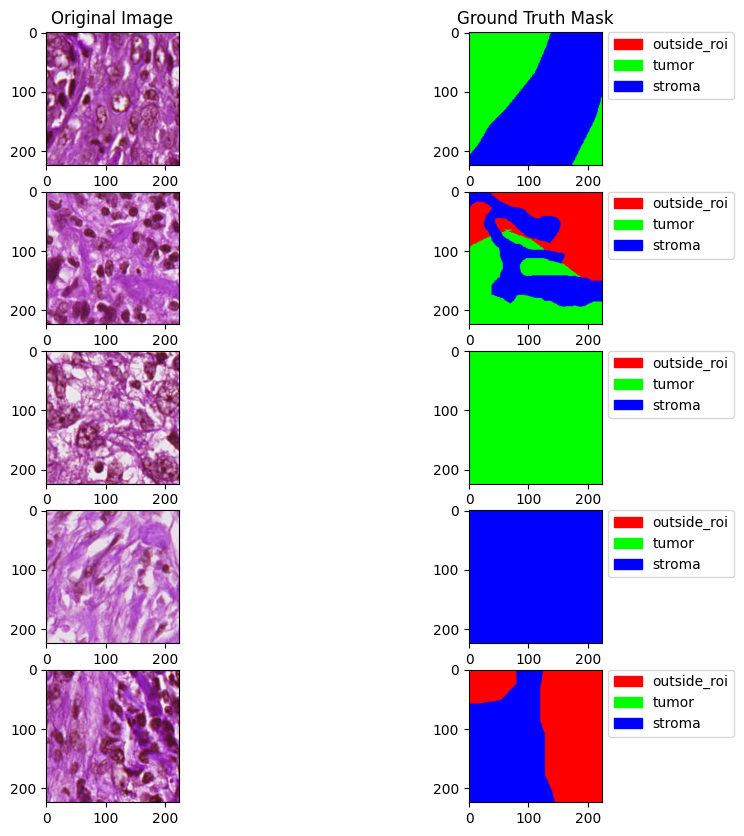

In [10]:
random_inds = np.random.randint(0,len(train_images),5)
images_exp = []
mask_images_exp = []
for i in random_inds:
    images_exp.append(train_images[i].copy())
    mask_images_exp.append(mask_images[i].copy())
PlotImage(images_exp,mask_images_exp,class_dict)

# Class Distrubition

In [11]:
count_dict = {"0" : 0, "1" : 0 , "2" : 0}
for i in range(len(mask_images)):
    pixels = mask_images[i].copy().flatten()
    classes,counts = np.unique(pixels,return_counts=True)
    
    for i in range(len(classes)):
        count_dict[str(classes[i])] += counts[i] / 3


count_dict

{'0': 39837508.0, '1': 66156839.0, '2': 44533653.0}

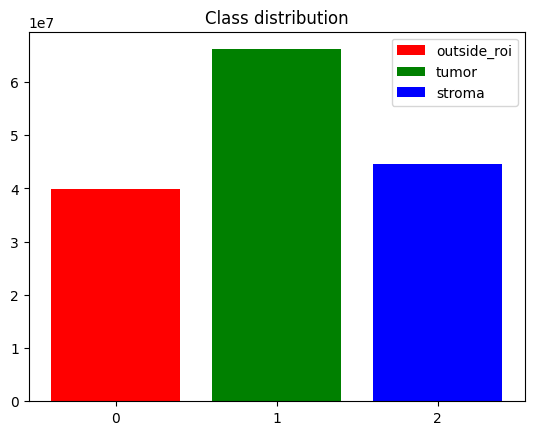

In [12]:
plt.bar(count_dict.keys(),count_dict.values(),label=["outside_roi","tumor","stroma"],color=["red","green","blue"])
plt.title("Class distribution")
plt.legend()

# Data Augmentation 

In [13]:
## Noise ve color change eklenebilir

def flip_rotation(img,mask):
    flip = np.random.randint(0,4)
    angle = np.random.randint(-45,45)
    flipped_img = cv2.flip(img,flip)
    flipped_mask = cv2.flip(mask,flip)

    rows,cols = img.shape[0],img.shape[1]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    rotated_img = cv2.warpAffine(flipped_img,M,(cols,rows))
    rotated_mask = cv2.warpAffine(flipped_mask,M,(cols,rows))
    return rotated_img,rotated_mask

images_augmented = []
masks_augmented = []
for i in range(len(train_images)):
    images_augmented.append(train_images[i])
    masks_augmented.append(mask_images[i])
    augmented_img,augmented_mask = flip_rotation(train_images[i].copy(),mask_images[i].copy())
    images_augmented.append(augmented_img)
    masks_augmented.append(augmented_mask)

images_augmented = np.array(images_augmented)
masks_augmented = np.array(masks_augmented)

In [14]:
val_images = np.array(images_augmented[:500])
val_masks = np.array(masks_augmented[:500])
images_augmented = np.array(images_augmented[500:6000])
masks_augmented = np.array(masks_augmented[500:6000])
images_augmented = images_augmented / 255.0
val_images = val_images / 255.0
masks_onehot = preprocess_mask(masks_augmented,3)
val_masks_onehot = preprocess_mask(val_masks,3)

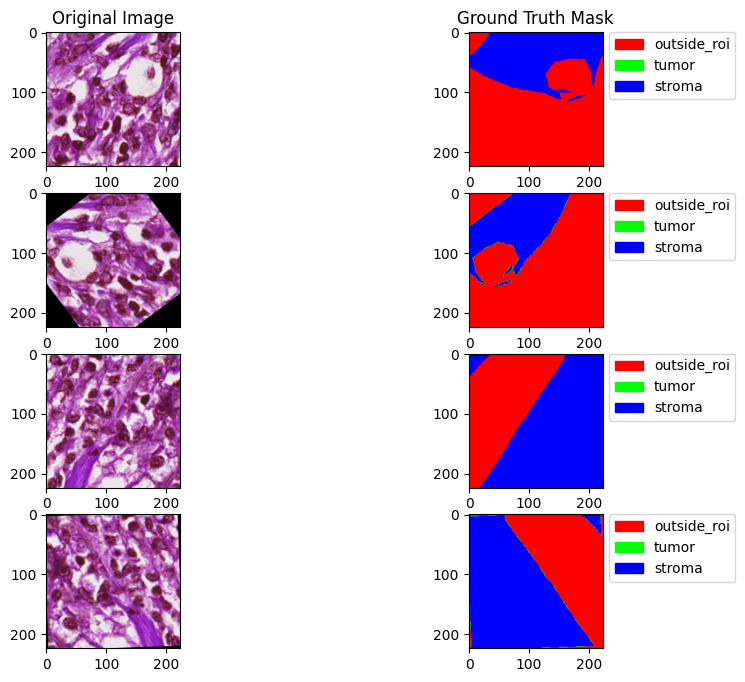

In [17]:

images_exp = []
mask_images_exp = []
start_ind = np.random.randint(0,len(images_augmented)-8,1)[0]
for i in range(start_ind,start_ind+4):
    images_exp.append(images_augmented[i].copy())
    mask_images_exp.append(masks_augmented[i].copy())
PlotImage(images_exp,mask_images_exp,class_dict)


# Custom U-Net Model

In [12]:
import torch
import torch.nn as nn
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class DoubleConv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(DoubleConv,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self,x):
        return self.conv(x)

class Unet(nn.Module):
    def __init__(self,input_channel = 3, out_channel = 3, filter_sizes = [32,64,128]):
        super(Unet,self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.softmax = nn.Softmax2d()

        #Encoder
        for i in filter_sizes:
            self.encoder.append(DoubleConv(input_channel,i))
            input_channel = i
        
        #Decoder
        for i in reversed(filter_sizes):
            self.decoder.append(nn.ConvTranspose2d(i*2,i,kernel_size=2,stride=2))
            self.decoder.append(DoubleConv(i*2,i))
       
        self.bottleneck = DoubleConv(filter_sizes[-1],filter_sizes[-1]*2)
        self.final_layer = nn.Conv2d(filter_sizes[0],out_channel,kernel_size=1)

    def forward(self,x):
        connections = []
        for enc in self.encoder:
            x = enc(x)
            connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        connections = connections[::-1]
        for index in range(0,len(self.decoder),2):
            x = self.decoder[index](x)
            connection = connections[index//2]
            if x.shape != connection.shape:
                x = nn.functional.interpolate(x,size = connection.shape[2:])
            concat_connection = torch.cat([connection,x],dim=1)
            x = self.decoder[index+1](concat_connection)
        
        x = self.final_layer(x)
        
        x  = self.softmax(x)
       
        return x
        #return nn.Softmax(dim=1)(x)
    
    def train(self,images,masks,val_images,val_masks,epochs,learning_rate,batch_size = 32):
        optimizer = torch.optim.Adam(self.parameters(),lr = learning_rate)
        criterion = nn.CrossEntropyLoss()
        epoch_loss = []
        epoch_val_loss = []
        for epoch in (range(epochs)):
            training_losses = []
            validation_losses = []

            for i in tqdm(range(0,len(images),batch_size)):
                optimizer.zero_grad()
                batch_images = torch.Tensor(images[i:i+batch_size]).permute(0,3,1,2).to(device)
                batch_masks = torch.Tensor(masks[i:i+batch_size]).permute(0,3,1,2).to(device)
                preds = self(batch_images)
                
                loss = criterion(preds,batch_masks)
                loss.backward()
                
                optimizer.step()
                training_losses.append(loss.item())
            
            for i in (range(0,len(val_images),batch_size)):
                optimizer.zero_grad()
                batch_images = torch.Tensor(val_images[i:i+batch_size]).permute(0,3,1,2).to(device)
                batch_masks = torch.Tensor(val_masks[i:i+batch_size]).permute(0,3,1,2).to(device)
                preds = self(batch_images)
                
                loss = criterion(preds,batch_masks)
                
                validation_losses.append(loss.item())

            epoch_loss.append(np.mean(training_losses))
            epoch_val_loss.append(np.mean(validation_losses))
            

            
            
            
            print(f"Epoch : {epoch+1}, Training Loss : {np.mean(training_losses)}, Validation Loss : {np.mean(validation_losses)}")
        #return training_losses,validation_losses
        

    def predict(self,input_img):
        input_img = torch.Tensor(input_img).permute(0,3,1,2).to(device)
        prediction = self(input_img).permute(0,2,3,1)
        
        return prediction.cpu().detach().numpy()
            

## Model Training

In [18]:
model = Unet(3,3).to(device)

train_loss,val_loss = model.train(images_augmented,masks_onehot,val_images,val_masks_onehot,50,0.00001,batch_size=16)

  0%|          | 0/188 [00:00<?, ?it/s]

100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 1, Training Loss : 1.0545263014575268, Validation Loss : 1.0043591912835836


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 2, Training Loss : 1.0074519064832241, Validation Loss : 0.9595035389065742


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 3, Training Loss : 0.984267863821476, Validation Loss : 0.9432996176183224


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 4, Training Loss : 0.9710299249025102, Validation Loss : 0.9326285924762487


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 5, Training Loss : 0.9599902306465392, Validation Loss : 0.9251576270908117


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 6, Training Loss : 0.9505106499220463, Validation Loss : 0.9190445970743895


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 7, Training Loss : 0.9430673800884409, Validation Loss : 0.9143352061510086


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 8, Training Loss : 0.9367275272912168, Validation Loss : 0.9108883049339056


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 9, Training Loss : 0.930955540626607, Validation Loss : 0.9083218015730381


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 10, Training Loss : 0.9256233287618515, Validation Loss : 0.9061525333672762


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 11, Training Loss : 0.9206140035010398, Validation Loss : 0.9037119224667549


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 12, Training Loss : 0.9158145116364702, Validation Loss : 0.9010641220957041


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 13, Training Loss : 0.9112461247342698, Validation Loss : 0.8983664885163307


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 14, Training Loss : 0.9068746170464982, Validation Loss : 0.8958432786166668


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 15, Training Loss : 0.9025536328554153, Validation Loss : 0.8936180491000414


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 16, Training Loss : 0.8982937114035829, Validation Loss : 0.8916355576366186


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 17, Training Loss : 0.8941647115539997, Validation Loss : 0.889852661639452


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 18, Training Loss : 0.8902173143752078, Validation Loss : 0.8882481642067432


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 19, Training Loss : 0.8864632740299753, Validation Loss : 0.8867282178252935


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 20, Training Loss : 0.8828726648650271, Validation Loss : 0.8852792382240295


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 21, Training Loss : 0.8794214326016446, Validation Loss : 0.8838854655623436


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 22, Training Loss : 0.876065155927171, Validation Loss : 0.8825985342264175


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 23, Training Loss : 0.8728024740802481, Validation Loss : 0.881449531763792


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 24, Training Loss : 0.8696100902050099, Validation Loss : 0.8804388046264648


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 25, Training Loss : 0.8664754400862024, Validation Loss : 0.8794966898858547


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 26, Training Loss : 0.8634145526175804, Validation Loss : 0.8786215055733919


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 27, Training Loss : 0.8604184262295986, Validation Loss : 0.877845760434866


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 28, Training Loss : 0.8575016662795493, Validation Loss : 0.87706184014678


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 29, Training Loss : 0.8546548298698791, Validation Loss : 0.8763075694441795


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 30, Training Loss : 0.8518683682096765, Validation Loss : 0.8755158353596926


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 31, Training Loss : 0.8491242667461963, Validation Loss : 0.8747392036020756


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 32, Training Loss : 0.8464250872109799, Validation Loss : 0.8738943543285131


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 33, Training Loss : 0.8437768151151374, Validation Loss : 0.8729751575738192


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 34, Training Loss : 0.8411637069062984, Validation Loss : 0.8721138574182987


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 35, Training Loss : 0.8385726238818879, Validation Loss : 0.8711870592087507


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 36, Training Loss : 0.836009161903503, Validation Loss : 0.8702519536018372


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 37, Training Loss : 0.8334774501780247, Validation Loss : 0.8693534769117832


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 38, Training Loss : 0.8309874255606469, Validation Loss : 0.8683301750570536


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 39, Training Loss : 0.828544445811434, Validation Loss : 0.8673161044716835


100%|██████████| 188/188 [03:42<00:00,  1.18s/it]


Epoch : 40, Training Loss : 0.8261060331096041, Validation Loss : 0.8662770166993141


100%|██████████| 188/188 [04:23<00:00,  1.40s/it]


Epoch : 41, Training Loss : 0.8236985520479527, Validation Loss : 0.865242350846529


100%|██████████| 188/188 [04:35<00:00,  1.47s/it]


Epoch : 42, Training Loss : 0.8213171822593567, Validation Loss : 0.8641968201845884


100%|██████████| 188/188 [04:35<00:00,  1.47s/it]


Epoch : 43, Training Loss : 0.8189602877865446, Validation Loss : 0.8631258998066187


100%|██████████| 188/188 [04:35<00:00,  1.47s/it]


Epoch : 44, Training Loss : 0.816619559171352, Validation Loss : 0.862105630338192


100%|██████████| 188/188 [04:35<00:00,  1.47s/it]


Epoch : 45, Training Loss : 0.8142974154746279, Validation Loss : 0.8610776513814926


100%|██████████| 188/188 [04:35<00:00,  1.47s/it]


Epoch : 46, Training Loss : 0.8119885141545153, Validation Loss : 0.8600445352494717


100%|██████████| 188/188 [04:35<00:00,  1.47s/it]


Epoch : 47, Training Loss : 0.8096804181311993, Validation Loss : 0.8590082060545683


100%|██████████| 188/188 [04:36<00:00,  1.47s/it]


Epoch : 48, Training Loss : 0.8073866532203999, Validation Loss : 0.8580085225403309


100%|██████████| 188/188 [04:35<00:00,  1.47s/it]


Epoch : 49, Training Loss : 0.8050924599804776, Validation Loss : 0.8571121636778116


100%|██████████| 188/188 [04:35<00:00,  1.47s/it]


Epoch : 50, Training Loss : 0.8028227788336734, Validation Loss : 0.856197252869606


In [21]:
# save weights
torch.save(model.state_dict(), "model_weights50.pth")


In [16]:
model = Unet(3,3).to(device)
model.load_state_dict(torch.load("model_weights50.pth"))


<All keys matched successfully>

In [17]:
model.train(images_augmented,masks_onehot,val_images,val_masks_onehot,30,0.00001,batch_size=16)

c:\Users\burak\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 188/188 [04:51<00:00,  1.55s/it]


Epoch : 1, Training Loss : 0.7946096227524129, Validation Loss : 0.8153680749237537


100%|██████████| 188/188 [04:46<00:00,  1.53s/it]


Epoch : 2, Training Loss : 0.7850433331220708, Validation Loss : 0.8135299868881702


100%|██████████| 188/188 [04:38<00:00,  1.48s/it]


Epoch : 3, Training Loss : 0.7775522686065511, Validation Loss : 0.8130504693835974


100%|██████████| 188/188 [04:39<00:00,  1.48s/it]


Epoch : 4, Training Loss : 0.7737573756182448, Validation Loss : 0.8125260937958956


100%|██████████| 188/188 [04:38<00:00,  1.48s/it]


Epoch : 5, Training Loss : 0.7707338929176331, Validation Loss : 0.8118598628789186


100%|██████████| 188/188 [04:38<00:00,  1.48s/it]


Epoch : 6, Training Loss : 0.7680417936533055, Validation Loss : 0.8109414782375097


100%|██████████| 188/188 [04:30<00:00,  1.44s/it]


Epoch : 7, Training Loss : 0.7655753525013619, Validation Loss : 0.8099281154572964


100%|██████████| 188/188 [04:25<00:00,  1.41s/it]


Epoch : 8, Training Loss : 0.7632585256657702, Validation Loss : 0.8089282531291246


100%|██████████| 188/188 [04:45<00:00,  1.52s/it]


Epoch : 9, Training Loss : 0.7611171260793158, Validation Loss : 0.8079199586063623


100%|██████████| 188/188 [05:32<00:00,  1.77s/it]


Epoch : 10, Training Loss : 0.7590950936713117, Validation Loss : 0.8070779759436846


100%|██████████| 188/188 [05:31<00:00,  1.76s/it]


Epoch : 11, Training Loss : 0.7572097873434107, Validation Loss : 0.8064250368624926


100%|██████████| 188/188 [05:44<00:00,  1.83s/it]


Epoch : 12, Training Loss : 0.7553976086225915, Validation Loss : 0.8058951180428267


100%|██████████| 188/188 [05:45<00:00,  1.84s/it]


Epoch : 13, Training Loss : 0.753655659708571, Validation Loss : 0.805560065433383


100%|██████████| 188/188 [05:38<00:00,  1.80s/it]


Epoch : 14, Training Loss : 0.7519711677698379, Validation Loss : 0.8052438832819462


100%|██████████| 188/188 [05:40<00:00,  1.81s/it]


Epoch : 15, Training Loss : 0.7503677682673677, Validation Loss : 0.805111039429903


100%|██████████| 188/188 [05:23<00:00,  1.72s/it]


Epoch : 16, Training Loss : 0.7487870946209482, Validation Loss : 0.8049993552267551


100%|██████████| 188/188 [05:51<00:00,  1.87s/it]


Epoch : 17, Training Loss : 0.7472650278755959, Validation Loss : 0.8048223536461592


100%|██████████| 188/188 [05:53<00:00,  1.88s/it]


Epoch : 18, Training Loss : 0.7457740103944819, Validation Loss : 0.8046748749911785


100%|██████████| 188/188 [05:51<00:00,  1.87s/it]


Epoch : 19, Training Loss : 0.7442734780463767, Validation Loss : 0.8045394718647003


100%|██████████| 188/188 [05:45<00:00,  1.84s/it]


Epoch : 20, Training Loss : 0.7428000252297584, Validation Loss : 0.8043268471956253


100%|██████████| 188/188 [05:46<00:00,  1.84s/it]


Epoch : 21, Training Loss : 0.7413402523132081, Validation Loss : 0.8040309585630894


100%|██████████| 188/188 [05:02<00:00,  1.61s/it]


Epoch : 22, Training Loss : 0.7398821594233208, Validation Loss : 0.803707055747509


100%|██████████| 188/188 [04:37<00:00,  1.47s/it]


Epoch : 23, Training Loss : 0.7384590601667445, Validation Loss : 0.8033843617886305


100%|██████████| 188/188 [04:37<00:00,  1.48s/it]


Epoch : 24, Training Loss : 0.7370559348070875, Validation Loss : 0.8031336851418018


100%|██████████| 188/188 [04:38<00:00,  1.48s/it]


Epoch : 25, Training Loss : 0.7357012214178734, Validation Loss : 0.8029485065490007


100%|██████████| 188/188 [04:38<00:00,  1.48s/it]


Epoch : 26, Training Loss : 0.734372947761353, Validation Loss : 0.8027405496686697


100%|██████████| 188/188 [04:38<00:00,  1.48s/it]


Epoch : 27, Training Loss : 0.7330622143567876, Validation Loss : 0.802591485902667


100%|██████████| 188/188 [04:38<00:00,  1.48s/it]


Epoch : 28, Training Loss : 0.7317447741615012, Validation Loss : 0.8022964540868998


100%|██████████| 188/188 [04:38<00:00,  1.48s/it]


Epoch : 29, Training Loss : 0.7304618872226553, Validation Loss : 0.8021050039678812


100%|██████████| 188/188 [04:38<00:00,  1.48s/it]


Epoch : 30, Training Loss : 0.7291539178249684, Validation Loss : 0.8019417598843575


([0.6385122537612915,
  0.6930539011955261,
  0.6277546882629395,
  0.6354892253875732,
  0.8252899050712585,
  0.643133282661438,
  0.6036891937255859,
  0.7501115202903748,
  0.6174592971801758,
  0.6138120889663696,
  0.7718592882156372,
  0.6566638350486755,
  0.7271457314491272,
  0.857741117477417,
  0.8855321407318115,
  1.003930687904358,
  0.9181812405586243,
  0.7261327505111694,
  0.7269858121871948,
  0.7634879946708679,
  0.7752425074577332,
  0.7959398627281189,
  0.8250880241394043,
  0.7523601055145264,
  0.7549927234649658,
  0.7266451716423035,
  0.72765052318573,
  0.7573451995849609,
  0.7825759649276733,
  0.7513107061386108,
  0.71903395652771,
  0.6483985781669617,
  0.6964676380157471,
  0.7772268652915955,
  0.7191534042358398,
  0.6695917844772339,
  0.7575927972793579,
  0.7450477480888367,
  0.6763140559196472,
  0.7467001676559448,
  0.6413565278053284,
  0.7429189085960388,
  0.5865033864974976,
  0.7116941809654236,
  0.604439914226532,
  0.67302584648132

### Losses are written in list because training is done in different times. Losses are recorded in list below.

In [16]:
train_loss =[   1.0545263014575268,
                1.0074519064832241,
                0.984267863821476,
                0.9710299249025102,
                0.9599902306465392,
                0.9505106499220463,
                0.9430673800884409,
                0.9367275272912168,
                0.930955540626607,
                0.9256233287618515,
                0.9206140035010398,
                0.9158145116364702,
                0.9112461247342698,
                0.9068746170464982,
                0.9025536328554153,
                0.8982937114035829,
                0.8941647115539997,
                0.8902173143752078,
                0.8864632740299753,
                0.8828726648650271,
                0.8794214326016446,
                0.876065155927171,
                0.8728024740802481,
                0.8696100902050099,
                0.8664754400862024,
                0.8634145526175804,
                0.8604184262295986,
                0.8575016662795493,
                0.8546548298698791,
                0.8518683682096765,
                0.8491242667461963,
                0.8464250872109799,
                0.8437768151151374,
                0.8411637069062984,
                0.8385726238818879,
                0.836009161903503,
                0.8334774501780247, 
                0.8309874255606469, 
                0.828544445811434,
                0.8261060331096041,
                0.8236985520479527,
                0.8213171822593567,
                0.8189602877865446,
                0.816619559171352,
                0.8142974154746279,
                0.8119885141545153,
                0.8096804181311993,
                0.8073866532203999,
                0.8050924599804776,
                0.8028227788336734,
                0.7946096227524129,
                0.7850433331220708,
                0.7775522686065511,
                0.7737573756182448,
                0.7707338929176331,
                0.7680417936533055,
                0.7655753525013619,
                0.7632585256657702,
                0.7611171260793158,
                0.7590950936713117,
                0.7572097873434107,
                0.7553976086225915,
                0.753655659708571,
                0.7519711677698379,
                0.7503677682673677,
                0.7487870946209482,
                0.7472650278755959,
                0.7457740103944819,
                0.7442734780463767,
                0.7428000252297584,
                0.7413402523132081,
                0.7398821594233208,
                0.7384590601667445,
                0.7370559348070875,
                0.7357012214178734,
                0.734372947761353,
                0.7330622143567876,
                0.7317447741615012,
                0.7304618872226553,
                0.7291539178249684,
                0.7365536325155421,
                0.7345259994902509,
                0.7329682907525529,
                0.7315202558294256,
                0.7301186377063711,
                0.7287764143436513,
                0.7274757836093294,
                0.7261979437254845,
                0.7249482581590084,
                0.7237129915267864,
                0.7225009935333374,
                0.7213045060634613,
                0.720121849407541,
                0.7189650253412572,
                0.7178146591845979,
                0.7166808513884849,
                0.7155515985920075,
                0.7144411222097722,
                0.713336964553975,
                0.7122288942337036,
                0.7111313691798676,
                0.7100385693793602,
                0.7089435410626391,
                0.7078531523968311,
                0.7067604198100719,
                0.7056718341847683,
                0.7045729990969313,
                0.7034818244741318,
                0.7023810316273507,
                0.7012897774260095,
                0.8460214255650839,
                0.8349200512568156,
                0.8288329442342123,
                0.8361511166890462,
                0.8250178894996643,
                0.8073294593493143,
                0.8007731909751892,
                0.792085572083791,
                0.785966148853302,
                0.7799814891815186,
                0.7784720435142517,
0.7745933799743653,
0.7694670019149781,
0.7662335047721863,
0.7603525627454122,
0.7587032465934753,
0.7536894462903341,
0.7502049287160237,
0.7467482151985169,
0.7453522610664368,
0.7418578815460205,
0.7421123911539713,
0.7476694019635518,
0.7489026171366374,
0.7456946821212769,
0.7390965979894002,
0.7348868977228801,
0.7319570970535278,
0.733046996752421,
0.7454851400057475,
0.7277861488660177,
0.7275044444402059,
0.7235644683837891,
0.7246102037429809,
0.7248902006149291,
0.7242206247647603,
0.7201575709978739,
0.7145514055887858,
0.7136502799987793,
0.7103687335650126,
0.7060813743273417,
 0.7035010526974996,
   0.7049948865572612,
     0.7072442965507507, 
     0.7056108256975809, 
     0.7111504727999369, 
     0.6996322873433432, 
     0.7038720526695251, 
     0.6978085950215658, 
     0.6980797905921936,
       0.6978373924891154, 
       0.6917652700742086,
         0.6903430415789287, 
         0.6909261285463969, 
         0.6913625334103902, 
         0.6868937110900879, 
         0.6850494351387024, 
         0.6849355436960856, 
         0.6936133351325989, 
         0.6843679048220317, 
         0.6807259268760681, 
         0.6756805044809977, 
         0.6772535785039266, 
         0.6757057981491089, 
         0.6753499512672424, 
         0.6891462016105652, 
         0.6750243929227193, 
         0.6775061095555623, 
         0.6691641683578491, 
         0.6652938035329183
]  # First 180 epoch


val_loss = [
1.0043591912835836,
0.9595035389065742,
0.9432996176183224,
0.9326285924762487,
0.9251576270908117,
0.9190445970743895,
0.9143352061510086,
0.9108883049339056,
0.9083218015730381,
0.9061525333672762,
0.9037119224667549,
0.9010641220957041,
0.8983664885163307,
0.8958432786166668,
0.8936180491000414,
0.8916355576366186,
0.889852661639452,
0.8882481642067432,
0.8867282178252935,
0.8852792382240295,
0.8838854655623436,
0.8825985342264175,
0.881449531763792,
0.8804388046264648,
0.8794966898858547,
0.8786215055733919,
0.877845760434866,
0.87706184014678,
0.8763075694441795,
0.8755158353596926,
0.8747392036020756,
0.8738943543285131,
0.8729751575738192,
0.8721138574182987,
0.8711870592087507,
0.8702519536018372,
0.8693534769117832,
0.8683301750570536,
0.8673161044716835,
0.8662770166993141,
0.865242350846529,
0.8641968201845884,
0.8631258998066187,
0.862105630338192,
0.8610776513814926,
0.8600445352494717,
0.8590082060545683,
0.8580085225403309,
0.8571121636778116,
0.856197252869606,
0.8153680749237537,
0.8135299868881702,
0.8130504693835974,
0.8125260937958956,
0.8118598628789186,
0.8109414782375097,
0.8099281154572964,
0.8089282531291246,
0.8079199586063623,
0.8070779759436846,
0.8064250368624926,
0.8058951180428267,
0.805560065433383,
0.8052438832819462,
0.805111039429903,
0.8049993552267551,
0.8048223536461592,
0.8046748749911785,
0.8045394718647003,
0.8043268471956253,
0.8040309585630894,
0.803707055747509,
0.8033843617886305,
0.8031336851418018,
0.8029485065490007,
0.8027405496686697,
0.802591485902667,
0.8022964540868998,
0.8021050039678812,
0.8019417598843575,
0.8064446821808815,
0.804269652813673,
0.8034290093928576,
0.8029793612658978,
0.802753571420908,
0.8026049975305796,
0.8025197125971317,
0.8024069145321846,
0.8023103885352612,
0.8022332806140184,
0.8022346515208483,
0.8022626228630543,
0.8022291772067547,
0.8022176586091518,
0.802205603569746,
0.8021755889058113,
0.8021565079689026,
0.8021551892161369,
0.8020918555557728,
0.802124934270978,
0.8021713048219681,
0.8021357338875532,
0.8021268583834171,
0.8020633012056351,
0.8020794559270144,
0.8020926471799612,
0.802078403532505,
0.8021232858300209,
0.8021290805190802,
0.8022610768675804,
0.8689327575266361,
0.8334240689873695,
0.8306423649191856,
0.8182068727910519,
0.8178191222250462,
0.8144318871200085,
0.8070864006876945,
0.8024717662483454,
0.7990322504192591,
0.7932543624192476,
0.7859898004680872,
0.784551914781332,
0.7825760692358017,
0.7778369635343552,
0.7911620941013098,
0.7761885486543179,
0.7732948437333107,
0.7732630204409361,
0.773855971172452,
0.7710877712816,
0.7623190693557262,
0.788866002112627,
0.81833216547966,
0.8313802275806665,
0.770439401268959,
0.7636912725865841,
0.7648575343191624,
0.7831441946327686,
0.8536209389567375,
0.7697368916124105,
0.7473614700138569,
0.7635019086301327,
0.7536171022802591,
0.7426345273852348,
0.7470385152846575,
0.7456753496080637,
0.7521495781838894,
0.7522419262677431,
0.763613436371088,
0.7364959996193647,
0.7460642773658037,
 0.7179277073591948, 
 0.7486871834844351, 
 0.7719092033803463, 
 0.8038731757551432, 
 0.740738358348608, 
 0.7855946216732264,
   0.7390700913965702, 
   0.7656401228159666, 
   0.7479848526418209, 
   0.7335883360356092, 
   0.7175995633006096, 
   0.730911660939455, 
   0.7612098641693592, 
   0.7044590525329113, 
   0.7109584659337997, 
   0.7136036716401577, 
   0.7226357981562614, 
   0.727305606007576, 
   0.7051952108740807, 
   0.6971746515482664, 
   0.6981630176305771, 
   0.7146207746118307, 
   0.7028104271739721,
     0.8037685826420784,
       0.7059680800884962, 
       0.7562250476330519,
         0.7168076653033495, 
         0.7066161762923002,
 0.6983086448162794
 # First 180 Epoch
]

In [18]:
torch.save(model.state_dict(), "model_weights_80_Epoch.pth")

In [16]:
model = Unet(3,3).to(device)
model.load_state_dict(torch.load("model_weights_80_Epoch.pth"))

<All keys matched successfully>

In [17]:
train_loss,val_loss = model.train(images_augmented,masks_onehot,val_images,val_masks_onehot,30,0.00001,batch_size=16)

c:\Users\burak\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 188/188 [04:45<00:00,  1.52s/it]


Epoch : 1, Training Loss : 0.7365536325155421, Validation Loss : 0.8064446821808815


100%|██████████| 188/188 [04:43<00:00,  1.51s/it]


Epoch : 2, Training Loss : 0.7345259994902509, Validation Loss : 0.804269652813673


100%|██████████| 188/188 [04:43<00:00,  1.51s/it]


Epoch : 3, Training Loss : 0.7329682907525529, Validation Loss : 0.8034290093928576


100%|██████████| 188/188 [04:44<00:00,  1.51s/it]


Epoch : 4, Training Loss : 0.7315202558294256, Validation Loss : 0.8029793612658978


100%|██████████| 188/188 [04:45<00:00,  1.52s/it]


Epoch : 5, Training Loss : 0.7301186377063711, Validation Loss : 0.802753571420908


100%|██████████| 188/188 [04:45<00:00,  1.52s/it]


Epoch : 6, Training Loss : 0.7287764143436513, Validation Loss : 0.8026049975305796


100%|██████████| 188/188 [04:45<00:00,  1.52s/it]


Epoch : 7, Training Loss : 0.7274757836093294, Validation Loss : 0.8025197125971317


100%|██████████| 188/188 [04:45<00:00,  1.52s/it]


Epoch : 8, Training Loss : 0.7261979437254845, Validation Loss : 0.8024069145321846


100%|██████████| 188/188 [04:45<00:00,  1.52s/it]


Epoch : 9, Training Loss : 0.7249482581590084, Validation Loss : 0.8023103885352612


100%|██████████| 188/188 [04:45<00:00,  1.52s/it]


Epoch : 10, Training Loss : 0.7237129915267864, Validation Loss : 0.8022332806140184


100%|██████████| 188/188 [04:45<00:00,  1.52s/it]


Epoch : 11, Training Loss : 0.7225009935333374, Validation Loss : 0.8022346515208483


100%|██████████| 188/188 [04:45<00:00,  1.52s/it]


Epoch : 12, Training Loss : 0.7213045060634613, Validation Loss : 0.8022626228630543


100%|██████████| 188/188 [04:45<00:00,  1.52s/it]


Epoch : 13, Training Loss : 0.720121849407541, Validation Loss : 0.8022291772067547


100%|██████████| 188/188 [04:45<00:00,  1.52s/it]


Epoch : 14, Training Loss : 0.7189650253412572, Validation Loss : 0.8022176586091518


100%|██████████| 188/188 [04:45<00:00,  1.52s/it]


Epoch : 15, Training Loss : 0.7178146591845979, Validation Loss : 0.802205603569746


100%|██████████| 188/188 [04:45<00:00,  1.52s/it]


Epoch : 16, Training Loss : 0.7166808513884849, Validation Loss : 0.8021755889058113


100%|██████████| 188/188 [04:45<00:00,  1.52s/it]


Epoch : 17, Training Loss : 0.7155515985920075, Validation Loss : 0.8021565079689026


100%|██████████| 188/188 [04:45<00:00,  1.52s/it]


Epoch : 18, Training Loss : 0.7144411222097722, Validation Loss : 0.8021551892161369


100%|██████████| 188/188 [04:45<00:00,  1.52s/it]


Epoch : 19, Training Loss : 0.713336964553975, Validation Loss : 0.8020918555557728


100%|██████████| 188/188 [04:45<00:00,  1.52s/it]


Epoch : 20, Training Loss : 0.7122288942337036, Validation Loss : 0.802124934270978


100%|██████████| 188/188 [04:45<00:00,  1.52s/it]


Epoch : 21, Training Loss : 0.7111313691798676, Validation Loss : 0.8021713048219681


100%|██████████| 188/188 [04:45<00:00,  1.52s/it]


Epoch : 22, Training Loss : 0.7100385693793602, Validation Loss : 0.8021357338875532


100%|██████████| 188/188 [04:45<00:00,  1.52s/it]


Epoch : 23, Training Loss : 0.7089435410626391, Validation Loss : 0.8021268583834171


100%|██████████| 188/188 [04:45<00:00,  1.52s/it]


Epoch : 24, Training Loss : 0.7078531523968311, Validation Loss : 0.8020633012056351


100%|██████████| 188/188 [04:45<00:00,  1.52s/it]


Epoch : 25, Training Loss : 0.7067604198100719, Validation Loss : 0.8020794559270144


100%|██████████| 188/188 [04:45<00:00,  1.52s/it]


Epoch : 26, Training Loss : 0.7056718341847683, Validation Loss : 0.8020926471799612


100%|██████████| 188/188 [04:45<00:00,  1.52s/it]


Epoch : 27, Training Loss : 0.7045729990969313, Validation Loss : 0.802078403532505


100%|██████████| 188/188 [04:45<00:00,  1.52s/it]


Epoch : 28, Training Loss : 0.7034818244741318, Validation Loss : 0.8021232858300209


100%|██████████| 188/188 [04:45<00:00,  1.52s/it]


Epoch : 29, Training Loss : 0.7023810316273507, Validation Loss : 0.8021290805190802


100%|██████████| 188/188 [04:45<00:00,  1.52s/it]


Epoch : 30, Training Loss : 0.7012897774260095, Validation Loss : 0.8022610768675804


In [18]:
torch.save(model.state_dict(), "model_weights_110_Epoch.pth")

In [17]:
model = Unet(3,3).to(device)
model.load_state_dict(torch.load("model_weights_110_Epoch.pth"))

<All keys matched successfully>

In [18]:
train_l, validation_l = model.train(images_augmented,masks_onehot,val_images,val_masks_onehot,10,0.0001,batch_size=16)

c:\Users\burak\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 375/375 [08:08<00:00,  1.30s/it]


Epoch : 1, Training Loss : 0.8460214255650839, Validation Loss : 0.8689327575266361


100%|██████████| 375/375 [07:28<00:00,  1.20s/it]


Epoch : 2, Training Loss : 0.8349200512568156, Validation Loss : 0.8334240689873695


100%|██████████| 375/375 [07:28<00:00,  1.20s/it]


Epoch : 3, Training Loss : 0.8288329442342123, Validation Loss : 0.8306423649191856


100%|██████████| 375/375 [07:28<00:00,  1.20s/it]


Epoch : 4, Training Loss : 0.8361511166890462, Validation Loss : 0.8182068727910519


100%|██████████| 375/375 [07:28<00:00,  1.20s/it]


Epoch : 5, Training Loss : 0.8250178894996643, Validation Loss : 0.8178191222250462


100%|██████████| 375/375 [07:28<00:00,  1.20s/it]


Epoch : 6, Training Loss : 0.8073294593493143, Validation Loss : 0.8144318871200085


100%|██████████| 375/375 [07:28<00:00,  1.20s/it]


Epoch : 7, Training Loss : 0.8007731909751892, Validation Loss : 0.8070864006876945


100%|██████████| 375/375 [07:28<00:00,  1.20s/it]


Epoch : 8, Training Loss : 0.792085572083791, Validation Loss : 0.8024717662483454


100%|██████████| 375/375 [07:28<00:00,  1.20s/it]


Epoch : 9, Training Loss : 0.785966148853302, Validation Loss : 0.7990322504192591


100%|██████████| 375/375 [07:28<00:00,  1.20s/it]


Epoch : 10, Training Loss : 0.7799814891815186, Validation Loss : 0.7932543624192476


In [19]:
torch.save(model.state_dict(), "model_weights_120_Epoch.pth")

In [16]:
model = Unet(3,3).to(device)
model.load_state_dict(torch.load("model_weights_120_Epoch.pth"))
model.train(images_augmented,masks_onehot,val_images,val_masks_onehot,30,0.0001,batch_size=16)

c:\Users\burak\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 375/375 [10:46<00:00,  1.72s/it]


Epoch : 1, Training Loss : 0.7784720435142517, Validation Loss : 0.7859898004680872


100%|██████████| 375/375 [10:29<00:00,  1.68s/it]


Epoch : 2, Training Loss : 0.7745933799743653, Validation Loss : 0.784551914781332


100%|██████████| 375/375 [09:37<00:00,  1.54s/it]


Epoch : 3, Training Loss : 0.7694670019149781, Validation Loss : 0.7825760692358017


100%|██████████| 375/375 [07:56<00:00,  1.27s/it]


Epoch : 4, Training Loss : 0.7662335047721863, Validation Loss : 0.7778369635343552


100%|██████████| 375/375 [07:30<00:00,  1.20s/it]


Epoch : 5, Training Loss : 0.7603525627454122, Validation Loss : 0.7911620941013098


100%|██████████| 375/375 [07:26<00:00,  1.19s/it]


Epoch : 6, Training Loss : 0.7587032465934753, Validation Loss : 0.7761885486543179


100%|██████████| 375/375 [07:25<00:00,  1.19s/it]


Epoch : 7, Training Loss : 0.7536894462903341, Validation Loss : 0.7732948437333107


100%|██████████| 375/375 [07:25<00:00,  1.19s/it]


Epoch : 8, Training Loss : 0.7502049287160237, Validation Loss : 0.7732630204409361


100%|██████████| 375/375 [08:06<00:00,  1.30s/it]


Epoch : 9, Training Loss : 0.7467482151985169, Validation Loss : 0.773855971172452


100%|██████████| 375/375 [11:00<00:00,  1.76s/it]


Epoch : 10, Training Loss : 0.7453522610664368, Validation Loss : 0.7710877712816


100%|██████████| 375/375 [11:02<00:00,  1.77s/it]


Epoch : 11, Training Loss : 0.7418578815460205, Validation Loss : 0.7623190693557262


100%|██████████| 375/375 [10:25<00:00,  1.67s/it]


Epoch : 12, Training Loss : 0.7421123911539713, Validation Loss : 0.788866002112627


100%|██████████| 375/375 [10:49<00:00,  1.73s/it]


Epoch : 13, Training Loss : 0.7476694019635518, Validation Loss : 0.81833216547966


100%|██████████| 375/375 [11:37<00:00,  1.86s/it]


Epoch : 14, Training Loss : 0.7489026171366374, Validation Loss : 0.8313802275806665


100%|██████████| 375/375 [10:29<00:00,  1.68s/it]


Epoch : 15, Training Loss : 0.7456946821212769, Validation Loss : 0.770439401268959


100%|██████████| 375/375 [09:18<00:00,  1.49s/it]


Epoch : 16, Training Loss : 0.7390965979894002, Validation Loss : 0.7636912725865841


100%|██████████| 375/375 [07:26<00:00,  1.19s/it]


Epoch : 17, Training Loss : 0.7348868977228801, Validation Loss : 0.7648575343191624


100%|██████████| 375/375 [07:26<00:00,  1.19s/it]


Epoch : 18, Training Loss : 0.7319570970535278, Validation Loss : 0.7831441946327686


100%|██████████| 375/375 [07:25<00:00,  1.19s/it]


Epoch : 19, Training Loss : 0.733046996752421, Validation Loss : 0.8536209389567375


100%|██████████| 375/375 [07:25<00:00,  1.19s/it]


Epoch : 20, Training Loss : 0.7454851400057475, Validation Loss : 0.7697368916124105


100%|██████████| 375/375 [07:25<00:00,  1.19s/it]


Epoch : 21, Training Loss : 0.7277861488660177, Validation Loss : 0.7473614700138569


100%|██████████| 375/375 [07:25<00:00,  1.19s/it]


Epoch : 22, Training Loss : 0.7275044444402059, Validation Loss : 0.7635019086301327


100%|██████████| 375/375 [07:25<00:00,  1.19s/it]


Epoch : 23, Training Loss : 0.7235644683837891, Validation Loss : 0.7536171022802591


100%|██████████| 375/375 [07:25<00:00,  1.19s/it]


Epoch : 24, Training Loss : 0.7246102037429809, Validation Loss : 0.7426345273852348


100%|██████████| 375/375 [07:25<00:00,  1.19s/it]


Epoch : 25, Training Loss : 0.7248902006149291, Validation Loss : 0.7470385152846575


100%|██████████| 375/375 [07:25<00:00,  1.19s/it]


Epoch : 26, Training Loss : 0.7242206247647603, Validation Loss : 0.7456753496080637


100%|██████████| 375/375 [07:25<00:00,  1.19s/it]


Epoch : 27, Training Loss : 0.7201575709978739, Validation Loss : 0.7521495781838894


100%|██████████| 375/375 [07:27<00:00,  1.19s/it]


Epoch : 28, Training Loss : 0.7145514055887858, Validation Loss : 0.7522419262677431


100%|██████████| 375/375 [07:26<00:00,  1.19s/it]


Epoch : 29, Training Loss : 0.7136502799987793, Validation Loss : 0.763613436371088


100%|██████████| 375/375 [07:25<00:00,  1.19s/it]


Epoch : 30, Training Loss : 0.7103687335650126, Validation Loss : 0.7364959996193647


In [17]:
model.train(images_augmented,masks_onehot,val_images,val_masks_onehot,30,0.0001,batch_size=16)

100%|██████████| 375/375 [07:26<00:00,  1.19s/it]


Epoch : 1, Training Loss : 0.7060813743273417, Validation Loss : 0.7460642773658037


100%|██████████| 375/375 [07:26<00:00,  1.19s/it]


Epoch : 2, Training Loss : 0.7035010526974996, Validation Loss : 0.7179277073591948


100%|██████████| 375/375 [07:26<00:00,  1.19s/it]


Epoch : 3, Training Loss : 0.7049948865572612, Validation Loss : 0.7486871834844351


100%|██████████| 375/375 [07:26<00:00,  1.19s/it]


Epoch : 4, Training Loss : 0.7072442965507507, Validation Loss : 0.7719092033803463


100%|██████████| 375/375 [07:26<00:00,  1.19s/it]


Epoch : 5, Training Loss : 0.7056108256975809, Validation Loss : 0.8038731757551432


100%|██████████| 375/375 [07:26<00:00,  1.19s/it]


Epoch : 6, Training Loss : 0.7111504727999369, Validation Loss : 0.740738358348608


100%|██████████| 375/375 [07:26<00:00,  1.19s/it]


Epoch : 7, Training Loss : 0.6996322873433432, Validation Loss : 0.7855946216732264


100%|██████████| 375/375 [07:26<00:00,  1.19s/it]


Epoch : 8, Training Loss : 0.7038720526695251, Validation Loss : 0.7390700913965702


100%|██████████| 375/375 [07:26<00:00,  1.19s/it]


Epoch : 9, Training Loss : 0.6978085950215658, Validation Loss : 0.7656401228159666


100%|██████████| 375/375 [07:26<00:00,  1.19s/it]


Epoch : 10, Training Loss : 0.6980797905921936, Validation Loss : 0.7479848526418209


100%|██████████| 375/375 [07:26<00:00,  1.19s/it]


Epoch : 11, Training Loss : 0.6978373924891154, Validation Loss : 0.7335883360356092


100%|██████████| 375/375 [07:27<00:00,  1.19s/it]


Epoch : 12, Training Loss : 0.6917652700742086, Validation Loss : 0.7175995633006096


100%|██████████| 375/375 [07:26<00:00,  1.19s/it]


Epoch : 13, Training Loss : 0.6903430415789287, Validation Loss : 0.730911660939455


100%|██████████| 375/375 [07:26<00:00,  1.19s/it]


Epoch : 14, Training Loss : 0.6909261285463969, Validation Loss : 0.7612098641693592


100%|██████████| 375/375 [07:26<00:00,  1.19s/it]


Epoch : 15, Training Loss : 0.6913625334103902, Validation Loss : 0.7044590525329113


100%|██████████| 375/375 [07:26<00:00,  1.19s/it]


Epoch : 16, Training Loss : 0.6868937110900879, Validation Loss : 0.7109584659337997


100%|██████████| 375/375 [07:26<00:00,  1.19s/it]


Epoch : 17, Training Loss : 0.6850494351387024, Validation Loss : 0.7136036716401577


100%|██████████| 375/375 [07:26<00:00,  1.19s/it]


Epoch : 18, Training Loss : 0.6849355436960856, Validation Loss : 0.7226357981562614


100%|██████████| 375/375 [07:26<00:00,  1.19s/it]


Epoch : 19, Training Loss : 0.6936133351325989, Validation Loss : 0.727305606007576


100%|██████████| 375/375 [07:26<00:00,  1.19s/it]


Epoch : 20, Training Loss : 0.6843679048220317, Validation Loss : 0.7051952108740807


100%|██████████| 375/375 [07:26<00:00,  1.19s/it]


Epoch : 21, Training Loss : 0.6807259268760681, Validation Loss : 0.6971746515482664


100%|██████████| 375/375 [07:25<00:00,  1.19s/it]


Epoch : 22, Training Loss : 0.6756805044809977, Validation Loss : 0.6981630176305771


100%|██████████| 375/375 [07:25<00:00,  1.19s/it]


Epoch : 23, Training Loss : 0.6772535785039266, Validation Loss : 0.7146207746118307


100%|██████████| 375/375 [07:26<00:00,  1.19s/it]


Epoch : 24, Training Loss : 0.6757057981491089, Validation Loss : 0.7028104271739721


100%|██████████| 375/375 [07:26<00:00,  1.19s/it]


Epoch : 25, Training Loss : 0.6753499512672424, Validation Loss : 0.8037685826420784


100%|██████████| 375/375 [07:26<00:00,  1.19s/it]


Epoch : 26, Training Loss : 0.6891462016105652, Validation Loss : 0.7059680800884962


100%|██████████| 375/375 [07:26<00:00,  1.19s/it]


Epoch : 27, Training Loss : 0.6750243929227193, Validation Loss : 0.7562250476330519


100%|██████████| 375/375 [07:25<00:00,  1.19s/it]


Epoch : 28, Training Loss : 0.6775061095555623, Validation Loss : 0.7168076653033495


100%|██████████| 375/375 [07:26<00:00,  1.19s/it]


Epoch : 29, Training Loss : 0.6691641683578491, Validation Loss : 0.7066161762923002


100%|██████████| 375/375 [07:52<00:00,  1.26s/it]


Epoch : 30, Training Loss : 0.6652938035329183, Validation Loss : 0.6983086448162794


In [18]:
torch.save(model.state_dict(), "model_weights_180_Epoch.pth")

# Loss Plot (Custom Model)

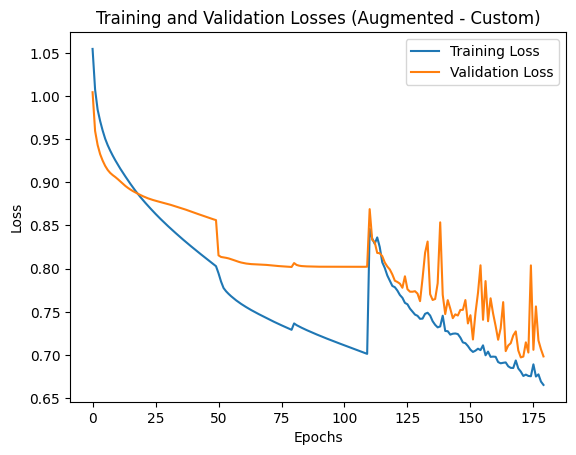

In [22]:
PlotLosses(train_loss,val_loss,"Training and Validation Losses (Augmented - Custom)")

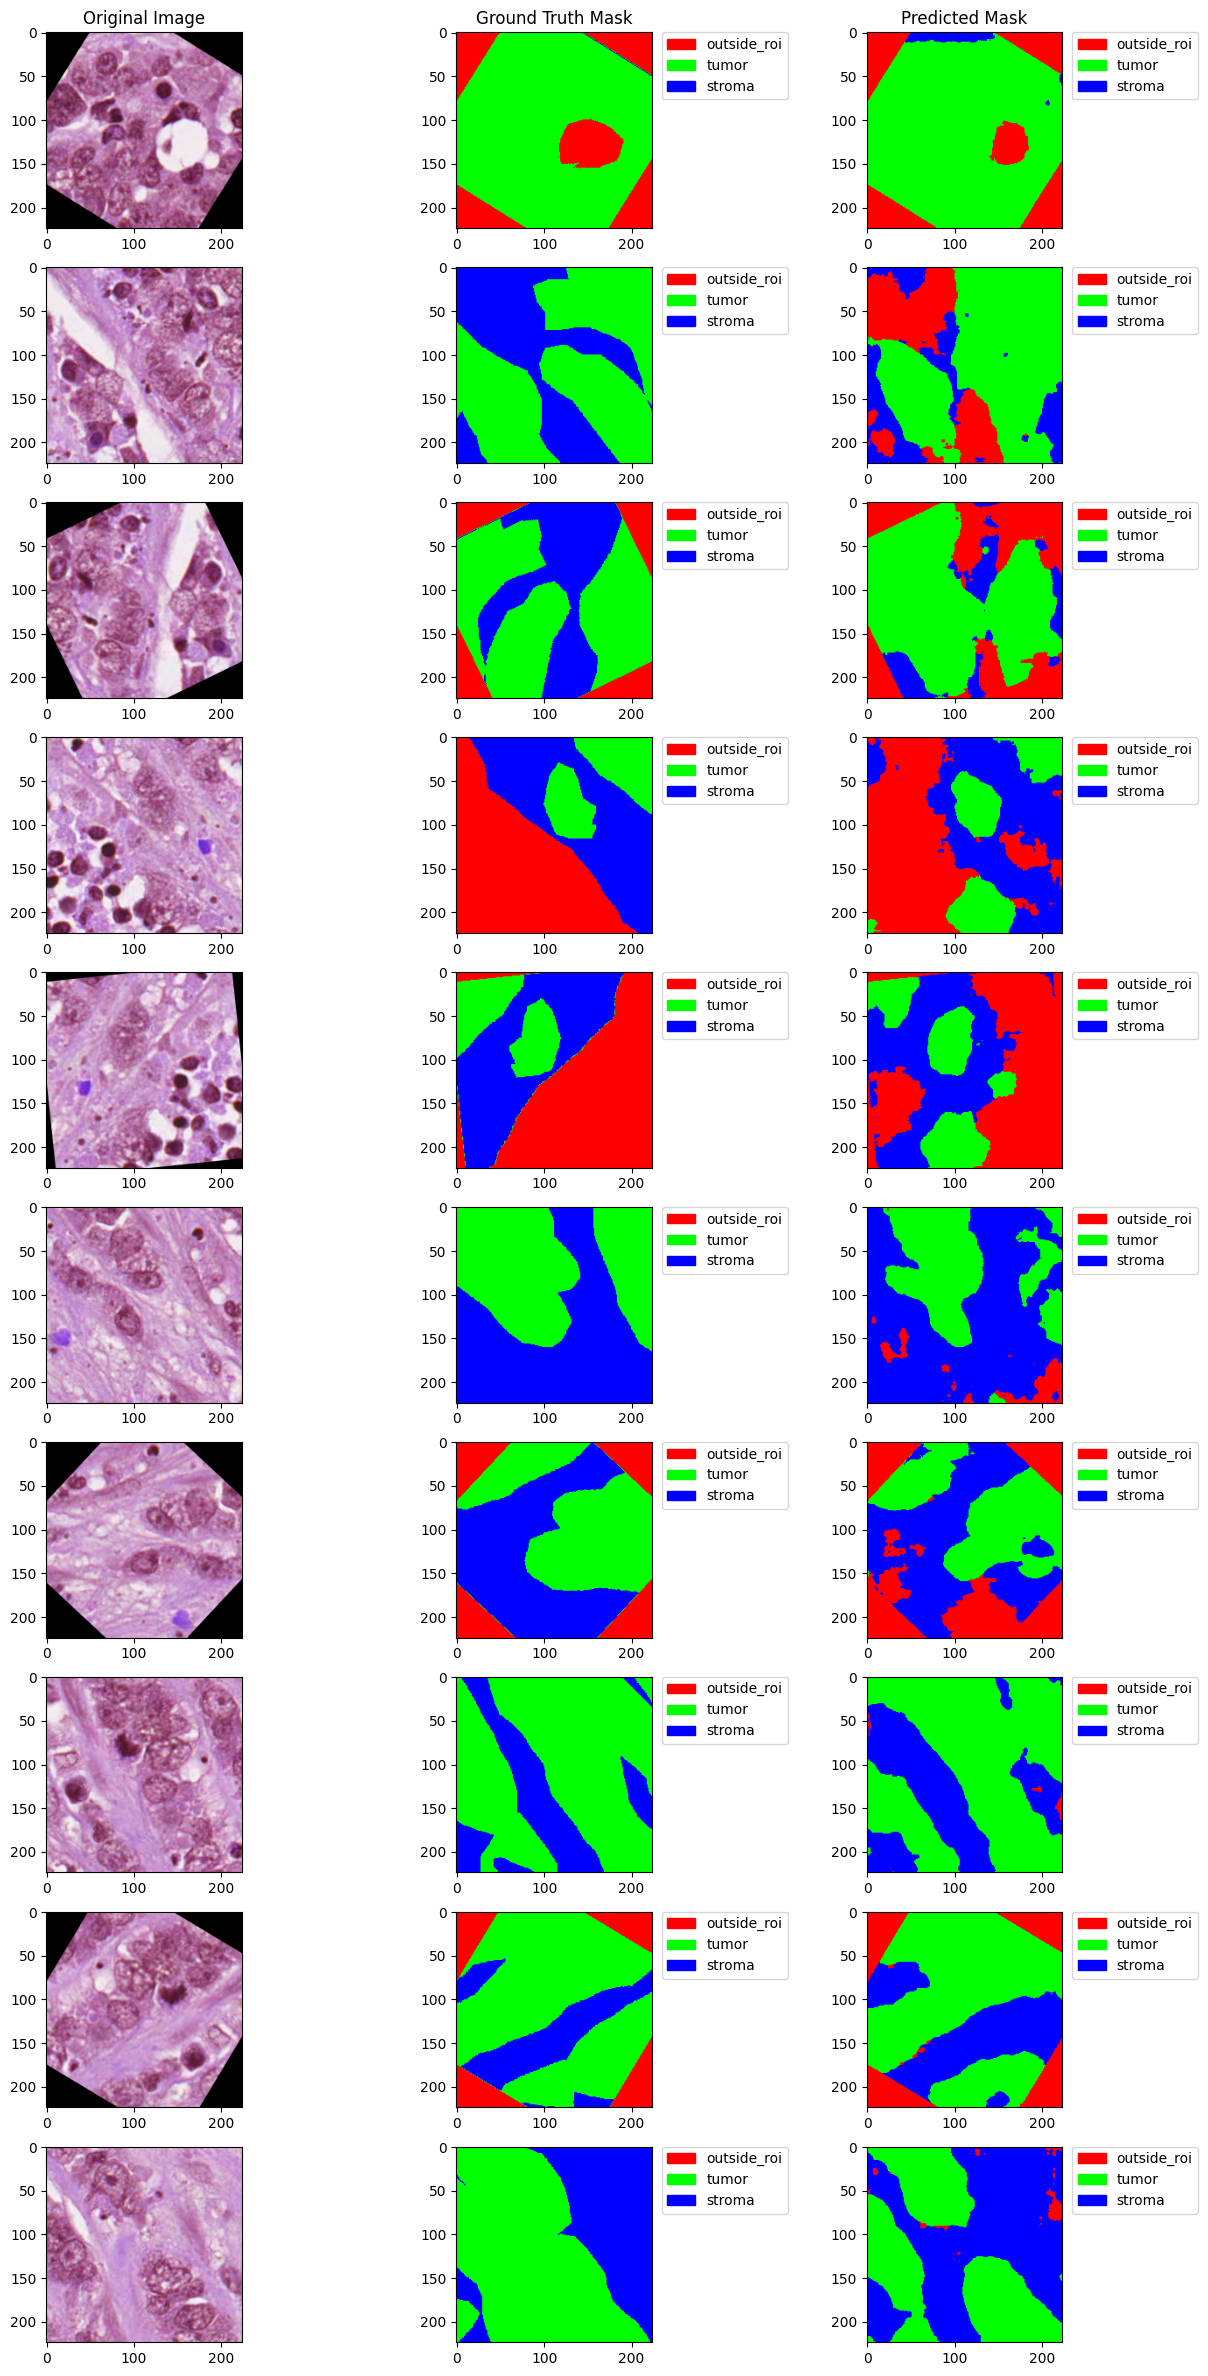

In [19]:
"""
## PREDICTION

model = Unet(3,3).to(device)
model.load_state_dict(torch.load("model_weights_110_Epoch.pth"))

preds = model.predict(val_images[15:25])
preds_masks = prediction_To_mask(preds,3)

PlotPredictions(val_images[15:25],val_masks[15:25],preds_masks,class_dict)
"""

In [ ]:
# https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/
# https://www.tensorflow.org/tutorials/images/segmentation?hl=tr

# Birkaç farklı model denenebilir.
# 15 min per epoch.

# Pretrained modelin lossları yazılacak.

# Pretrained Unet

In [23]:
def train(model,images,masks,val_images,val_masks,epochs,learning_rate,batch_size = 32):
        optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
        criterion = nn.CrossEntropyLoss()
        epoch_loss = []
        epoch_val_loss = []
        for epoch in (range(epochs)):
            training_losses = []
            validation_losses = []

            for i in tqdm(range(0,len(images),batch_size)):
                optimizer.zero_grad()
                batch_images = torch.Tensor(images[i:i+batch_size]).permute(0,3,1,2).to(device)
                batch_masks = torch.Tensor(masks[i:i+batch_size]).permute(0,3,1,2).to(device)
                preds = model(batch_images)
                
                loss = criterion(preds,batch_masks)
                loss.backward()
                
                optimizer.step()
                training_losses.append(loss.item())
            
            for i in (range(0,len(val_images),batch_size)):
                optimizer.zero_grad()
                batch_images = torch.Tensor(val_images[i:i+batch_size]).permute(0,3,1,2).to(device)
                batch_masks = torch.Tensor(val_masks[i:i+batch_size]).permute(0,3,1,2).to(device)
                preds = model(batch_images)
                
                loss = criterion(preds,batch_masks)
                
                validation_losses.append(loss.item())

            epoch_loss.append(np.mean(training_losses))
            epoch_val_loss.append(np.mean(validation_losses))
            

            
            
            
            print(f"Epoch : {epoch+1}, Training Loss : {np.mean(training_losses)}, Validation Loss : {np.mean(validation_losses)}")
        #return training_losses,validation_losses


def load_model(weights_path = None,gpu=True):
    Pretrained_Unet = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)
    Pretrained_Unet.conv = nn.Conv2d(32,3,kernel_size=1)
    
    for param in Pretrained_Unet.conv.parameters():
        param.requires_grad = True
    
    if gpu:
        Pretrained_Unet = Pretrained_Unet.to(device)
    if weights_path:
        Pretrained_Unet.load_state_dict(torch.load(weights_path))
        
    return Pretrained_Unet

## Training

In [54]:
Pretrained_Unet = load_model()

train(Pretrained_Unet,images_augmented,masks_onehot,val_images,val_masks_onehot,5,0.0001,batch_size=16)


Using cache found in C:\Users\burak/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master
100%|██████████| 375/375 [10:11<00:00,  1.63s/it]


Epoch : 1, Training Loss : 0.9822823321024576, Validation Loss : 0.9317976385354996


100%|██████████| 375/375 [10:09<00:00,  1.62s/it]


Epoch : 2, Training Loss : 0.9421891098022461, Validation Loss : 0.9108454640954733


100%|██████████| 375/375 [11:53<00:00,  1.90s/it]


Epoch : 3, Training Loss : 0.9221152523358663, Validation Loss : 0.8971266169101


100%|██████████| 375/375 [14:15<00:00,  2.28s/it]


Epoch : 4, Training Loss : 0.9065101345380148, Validation Loss : 0.8884443156421185


100%|██████████| 375/375 [10:28<00:00,  1.68s/it]


Epoch : 5, Training Loss : 0.8914694390296936, Validation Loss : 0.8758832234889269


In [55]:
torch.save(Pretrained_Unet.state_dict(), "Pretrained_Unet_5_Epoch.pth")

In [56]:
Pretrained_Unet = load_model("Pretrained_Unet_5_Epoch.pth")

train(Pretrained_Unet,images_augmented,masks_onehot,val_images,val_masks_onehot,5,0.0001,batch_size=16)

Using cache found in C:\Users\burak/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master
100%|██████████| 375/375 [08:06<00:00,  1.30s/it]


Epoch : 1, Training Loss : 0.8732777679761251, Validation Loss : 0.8554413355886936


100%|██████████| 375/375 [08:06<00:00,  1.30s/it]


Epoch : 2, Training Loss : 0.8585487767855327, Validation Loss : 0.8354670349508524


100%|██████████| 375/375 [08:05<00:00,  1.30s/it]


Epoch : 3, Training Loss : 0.8440622140566508, Validation Loss : 0.8221630975604057


100%|██████████| 375/375 [08:59<00:00,  1.44s/it]


Epoch : 4, Training Loss : 0.8315802175203959, Validation Loss : 0.8110572546720505


100%|██████████| 375/375 [14:22<00:00,  2.30s/it]


Epoch : 5, Training Loss : 0.8193022238413493, Validation Loss : 0.8026860561221838


In [57]:
torch.save(Pretrained_Unet.state_dict(), "Pretrained_Unet_10_Epoch.pth")

In [58]:
Pretrained_Unet = load_model("Pretrained_Unet_10_Epoch.pth")
train(Pretrained_Unet,images_augmented,masks_onehot,val_images,val_masks_onehot,10,0.0001,batch_size=16)

Using cache found in C:\Users\burak/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master
100%|██████████| 375/375 [13:50<00:00,  2.22s/it]


Epoch : 1, Training Loss : 0.8063037414550781, Validation Loss : 0.7938103880733252


100%|██████████| 375/375 [09:36<00:00,  1.54s/it]


Epoch : 2, Training Loss : 0.7957505852381388, Validation Loss : 0.7879069913178682


100%|██████████| 375/375 [09:53<00:00,  1.58s/it]


Epoch : 3, Training Loss : 0.7871647008260091, Validation Loss : 0.7831413149833679


100%|██████████| 375/375 [10:58<00:00,  1.76s/it]


Epoch : 4, Training Loss : 0.7795991379419963, Validation Loss : 0.7793147154152393


100%|██████████| 375/375 [12:51<00:00,  2.06s/it]


Epoch : 5, Training Loss : 0.7728680378595988, Validation Loss : 0.7771556358784437


100%|██████████| 375/375 [10:06<00:00,  1.62s/it]


Epoch : 6, Training Loss : 0.7656799944241842, Validation Loss : 0.7748707290738821


100%|██████████| 375/375 [10:07<00:00,  1.62s/it]


Epoch : 7, Training Loss : 0.7578684711456298, Validation Loss : 0.773679981008172


100%|██████████| 375/375 [10:05<00:00,  1.61s/it]


Epoch : 8, Training Loss : 0.7513083035151163, Validation Loss : 0.7696848902851343


100%|██████████| 375/375 [10:02<00:00,  1.61s/it]


Epoch : 9, Training Loss : 0.7448482616742452, Validation Loss : 0.7720906231552362


100%|██████████| 375/375 [10:06<00:00,  1.62s/it]


Epoch : 10, Training Loss : 0.7469720290501912, Validation Loss : 0.7752330396324396


In [59]:
torch.save(Pretrained_Unet.state_dict(), "Pretrained_Unet_20_Epoch.pth")

In [16]:
Pretrained_Unet = load_model("Pretrained_Unet_20_Epoch.pth")
train(Pretrained_Unet,images_augmented,masks_onehot,val_images,val_masks_onehot,10,0.0001,batch_size=16)

Using cache found in C:\Users\burak/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master
c:\Users\burak\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 375/375 [08:00<00:00,  1.28s/it]


Epoch : 1, Training Loss : 0.7518038175900777, Validation Loss : 0.7665865980088711


100%|██████████| 375/375 [08:08<00:00,  1.30s/it]


Epoch : 2, Training Loss : 0.7412363886833191, Validation Loss : 0.763451112434268


100%|██████████| 375/375 [08:01<00:00,  1.28s/it]


Epoch : 3, Training Loss : 0.7336812176704407, Validation Loss : 0.7578549664467573


100%|██████████| 375/375 [08:01<00:00,  1.28s/it]


Epoch : 4, Training Loss : 0.727100323677063, Validation Loss : 0.7498851995915174


100%|██████████| 375/375 [08:01<00:00,  1.29s/it]


Epoch : 5, Training Loss : 0.72672567431132, Validation Loss : 0.7416762933135033


100%|██████████| 375/375 [08:05<00:00,  1.30s/it]


Epoch : 6, Training Loss : 0.7182721764246622, Validation Loss : 0.7332694437354803


100%|██████████| 375/375 [08:05<00:00,  1.29s/it]


Epoch : 7, Training Loss : 0.7168747248649597, Validation Loss : 0.7278176844120026


100%|██████████| 375/375 [08:03<00:00,  1.29s/it]


Epoch : 8, Training Loss : 0.7085010979970296, Validation Loss : 0.7264852076768875


100%|██████████| 375/375 [09:52<00:00,  1.58s/it]


Epoch : 9, Training Loss : 0.7046696707407634, Validation Loss : 0.7229684852063656


100%|██████████| 375/375 [12:21<00:00,  1.98s/it]


Epoch : 10, Training Loss : 0.7036214949289957, Validation Loss : 0.7327150963246822


In [17]:
train(Pretrained_Unet,images_augmented,masks_onehot,val_images,val_masks_onehot,5,0.0001,batch_size=16)

100%|██████████| 375/375 [11:28<00:00,  1.84s/it]


Epoch : 1, Training Loss : 0.7039218328793844, Validation Loss : 0.712713435292244


100%|██████████| 375/375 [10:58<00:00,  1.76s/it]


Epoch : 2, Training Loss : 0.7032158807118734, Validation Loss : 0.7078572791069746


100%|██████████| 375/375 [12:39<00:00,  2.03s/it]


Epoch : 3, Training Loss : 0.7020839443206787, Validation Loss : 0.7220737487077713


100%|██████████| 375/375 [11:58<00:00,  1.92s/it]


Epoch : 4, Training Loss : 0.69370880540212, Validation Loss : 0.7184052765369415


100%|██████████| 375/375 [10:26<00:00,  1.67s/it]


Epoch : 5, Training Loss : 0.6898301134109497, Validation Loss : 0.7022204324603081


In [18]:
torch.save(Pretrained_Unet.state_dict(), "Pretrained_Unet_35_Epoch.pth")

In [16]:
Pretrained_Unet = load_model("Pretrained_Unet_35_Epoch.pth")
train(Pretrained_Unet,images_augmented,masks_onehot,val_images,val_masks_onehot,20,0.0001,batch_size=16)

Using cache found in C:\Users\burak/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master
c:\Users\burak\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 375/375 [08:00<00:00,  1.28s/it]


Epoch : 1, Training Loss : 0.708211095015208, Validation Loss : 0.7195100504904985


100%|██████████| 375/375 [08:06<00:00,  1.30s/it]


Epoch : 2, Training Loss : 0.6986964076360067, Validation Loss : 0.7531520128250122


100%|██████████| 375/375 [08:06<00:00,  1.30s/it]


Epoch : 3, Training Loss : 0.6954052418073018, Validation Loss : 0.751140184700489


100%|██████████| 375/375 [08:05<00:00,  1.30s/it]


Epoch : 4, Training Loss : 0.6914050898551941, Validation Loss : 0.7192060183733702


100%|██████████| 375/375 [07:57<00:00,  1.27s/it]


Epoch : 5, Training Loss : 0.6860197809537252, Validation Loss : 0.76993053779006


100%|██████████| 375/375 [07:56<00:00,  1.27s/it]


Epoch : 6, Training Loss : 0.6871077709197998, Validation Loss : 0.7093793917447329


100%|██████████| 375/375 [07:56<00:00,  1.27s/it]


Epoch : 7, Training Loss : 0.6767243434588115, Validation Loss : 0.7001710794866085


100%|██████████| 375/375 [07:56<00:00,  1.27s/it]


Epoch : 8, Training Loss : 0.6744731992085775, Validation Loss : 0.6932916026562452


100%|██████████| 375/375 [07:56<00:00,  1.27s/it]


Epoch : 9, Training Loss : 0.6747451594670614, Validation Loss : 0.7166586462408304


100%|██████████| 375/375 [08:02<00:00,  1.29s/it]


Epoch : 10, Training Loss : 0.6710687257448832, Validation Loss : 0.6962181478738785


100%|██████████| 375/375 [12:22<00:00,  1.98s/it]


Epoch : 11, Training Loss : 0.665117877960205, Validation Loss : 0.6890651267021894


100%|██████████| 375/375 [11:52<00:00,  1.90s/it]


Epoch : 12, Training Loss : 0.6602811536788941, Validation Loss : 0.7009454797953367


100%|██████████| 375/375 [12:19<00:00,  1.97s/it]


Epoch : 13, Training Loss : 0.6612300008138021, Validation Loss : 0.6956925988197327


100%|██████████| 375/375 [11:27<00:00,  1.83s/it]


Epoch : 14, Training Loss : 0.6589036196072896, Validation Loss : 0.6985394135117531


100%|██████████| 375/375 [11:38<00:00,  1.86s/it]


Epoch : 15, Training Loss : 0.6564111464818319, Validation Loss : 0.685703756287694


100%|██████████| 375/375 [10:07<00:00,  1.62s/it]


Epoch : 16, Training Loss : 0.6509923030535381, Validation Loss : 0.7089629974216223


100%|██████████| 375/375 [10:26<00:00,  1.67s/it]


Epoch : 17, Training Loss : 0.6468276104927063, Validation Loss : 0.6814414095133543


100%|██████████| 375/375 [09:50<00:00,  1.58s/it]


Epoch : 18, Training Loss : 0.6462994106610616, Validation Loss : 0.6986004244536161


100%|██████████| 375/375 [08:33<00:00,  1.37s/it]


Epoch : 19, Training Loss : 0.64034858751297, Validation Loss : 0.6834107544273138


100%|██████████| 375/375 [10:18<00:00,  1.65s/it]


Epoch : 20, Training Loss : 0.6371350876490275, Validation Loss : 0.6871958952397108


In [17]:
torch.save(Pretrained_Unet.state_dict(), "Pretrained_Unet_55_Epoch.pth")

### Losses are written in list because training is done in different times. Losses are recorded in list below.

In [24]:
train_loss = [0.9822823321024576,
              0.9421891098022461,
              0.9221152523358663,
              0.9065101345380148,
              0.8914694390296936,
              0.8732777679761251,
              0.8585487767855327,
              0.8440622140566508,
              0.8315802175203959,
              0.8193022238413493,
              0.8063037414550781,
              0.7957505852381388,
              0.7871647008260091,
              0.7795991379419963,
              0.7728680378595988,
              0.7656799944241842,
               0.7578684711456298,
               0.7513083035151163,
               0.7448482616742452,
               0.7469720290501912, 
0.7518038175900777, 
0.7412363886833191, 
0.7336812176704407, 
0.727100323677063, 
0.72672567431132, 
0.7182721764246622,
 0.7168747248649597,
   0.7085010979970296,
     0.7046696707407634, 
     0.7036214949289957,
     0.7039218328793844,
0.7032158807118734,
0.7020839443206787,
0.69370880540212,
0.6898301134109497,
0.708211095015208,
0.6986964076360067,
0.6954052418073018,
0.6914050898551941,
0.6860197809537252,
0.6871077709197998,
0.6767243434588115,
0.6744731992085775,
0.6747451594670614,
0.6710687257448832,
0.665117877960205,
0.6602811536788941,
0.6612300008138021,
0.6589036196072896,
0.6564111464818319,
0.6509923030535381,
0.6468276104927063,
0.6462994106610616,
0.64034858751297,
0.6371350876490275
]
val_loss = [0.9317976385354996,
0.9108454640954733,
0.8971266169101,
0.8884443156421185,
0.8758832234889269,
0.8554413355886936,
0.8354670349508524,
0.8221630975604057,
0.8110572546720505,
0.8026860561221838,
0.7938103880733252,
0.7879069913178682,
0.7831413149833679,
0.7793147154152393,
0.7771556358784437,
0.7748707290738821,
0.773679981008172,
0.7696848902851343,
0.7720906231552362,
0.7752330396324396,
0.7665865980088711,
0.763451112434268,
0.7578549664467573,
0.7498851995915174,
0.7416762933135033,
0.7332694437354803,
0.7278176844120026,
0.7264852076768875,
0.7229684852063656,
0.7327150963246822,
0.712713435292244,
0.7078572791069746,
0.7220737487077713,
0.7184052765369415,
0.7022204324603081,

0.7195100504904985,
0.7531520128250122,
0.751140184700489,
0.7192060183733702,
0.76993053779006,
0.7093793917447329,
0.7001710794866085,
0.6932916026562452,
0.7166586462408304,
0.6962181478738785,
0.6890651267021894,
0.7009454797953367,
0.6956925988197327,
0.6985394135117531,
0.685703756287694,
0.7089629974216223,
0.6814414095133543,
0.6986004244536161,
0.6834107544273138,
0.6871958952397108
]

# Loss Plot (Pretrained Model)

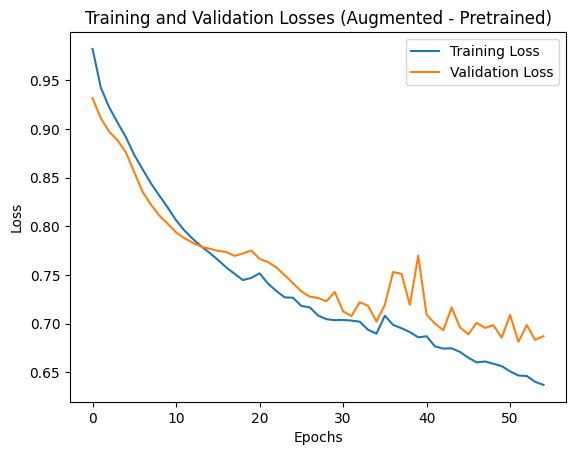

In [25]:
PlotLosses(train_loss,val_loss,title= "Training and Validation Losses (Augmented - Pretrained)")

## Loading Model

In [36]:
import torch
Pretrained_Unet = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)
Pretrained_Unet.conv = nn.Conv2d(32,3,kernel_size=1)
#Pretrained_Unet = Pretrained_Unet.to(device)
Pretrained_Unet.load_state_dict(torch.load("Pretrained_Unet_65_Epoch.pth"))

Using cache found in C:\Users\burak/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


<All keys matched successfully>

# Model Evaluation

In [47]:
output = Pretrained_Unet(torch.Tensor(val_images[265:275]).permute(0,3,1,2)).permute(0,2,3,1).detach().numpy()

In [48]:
mask_output = prediction_To_mask(output,3)

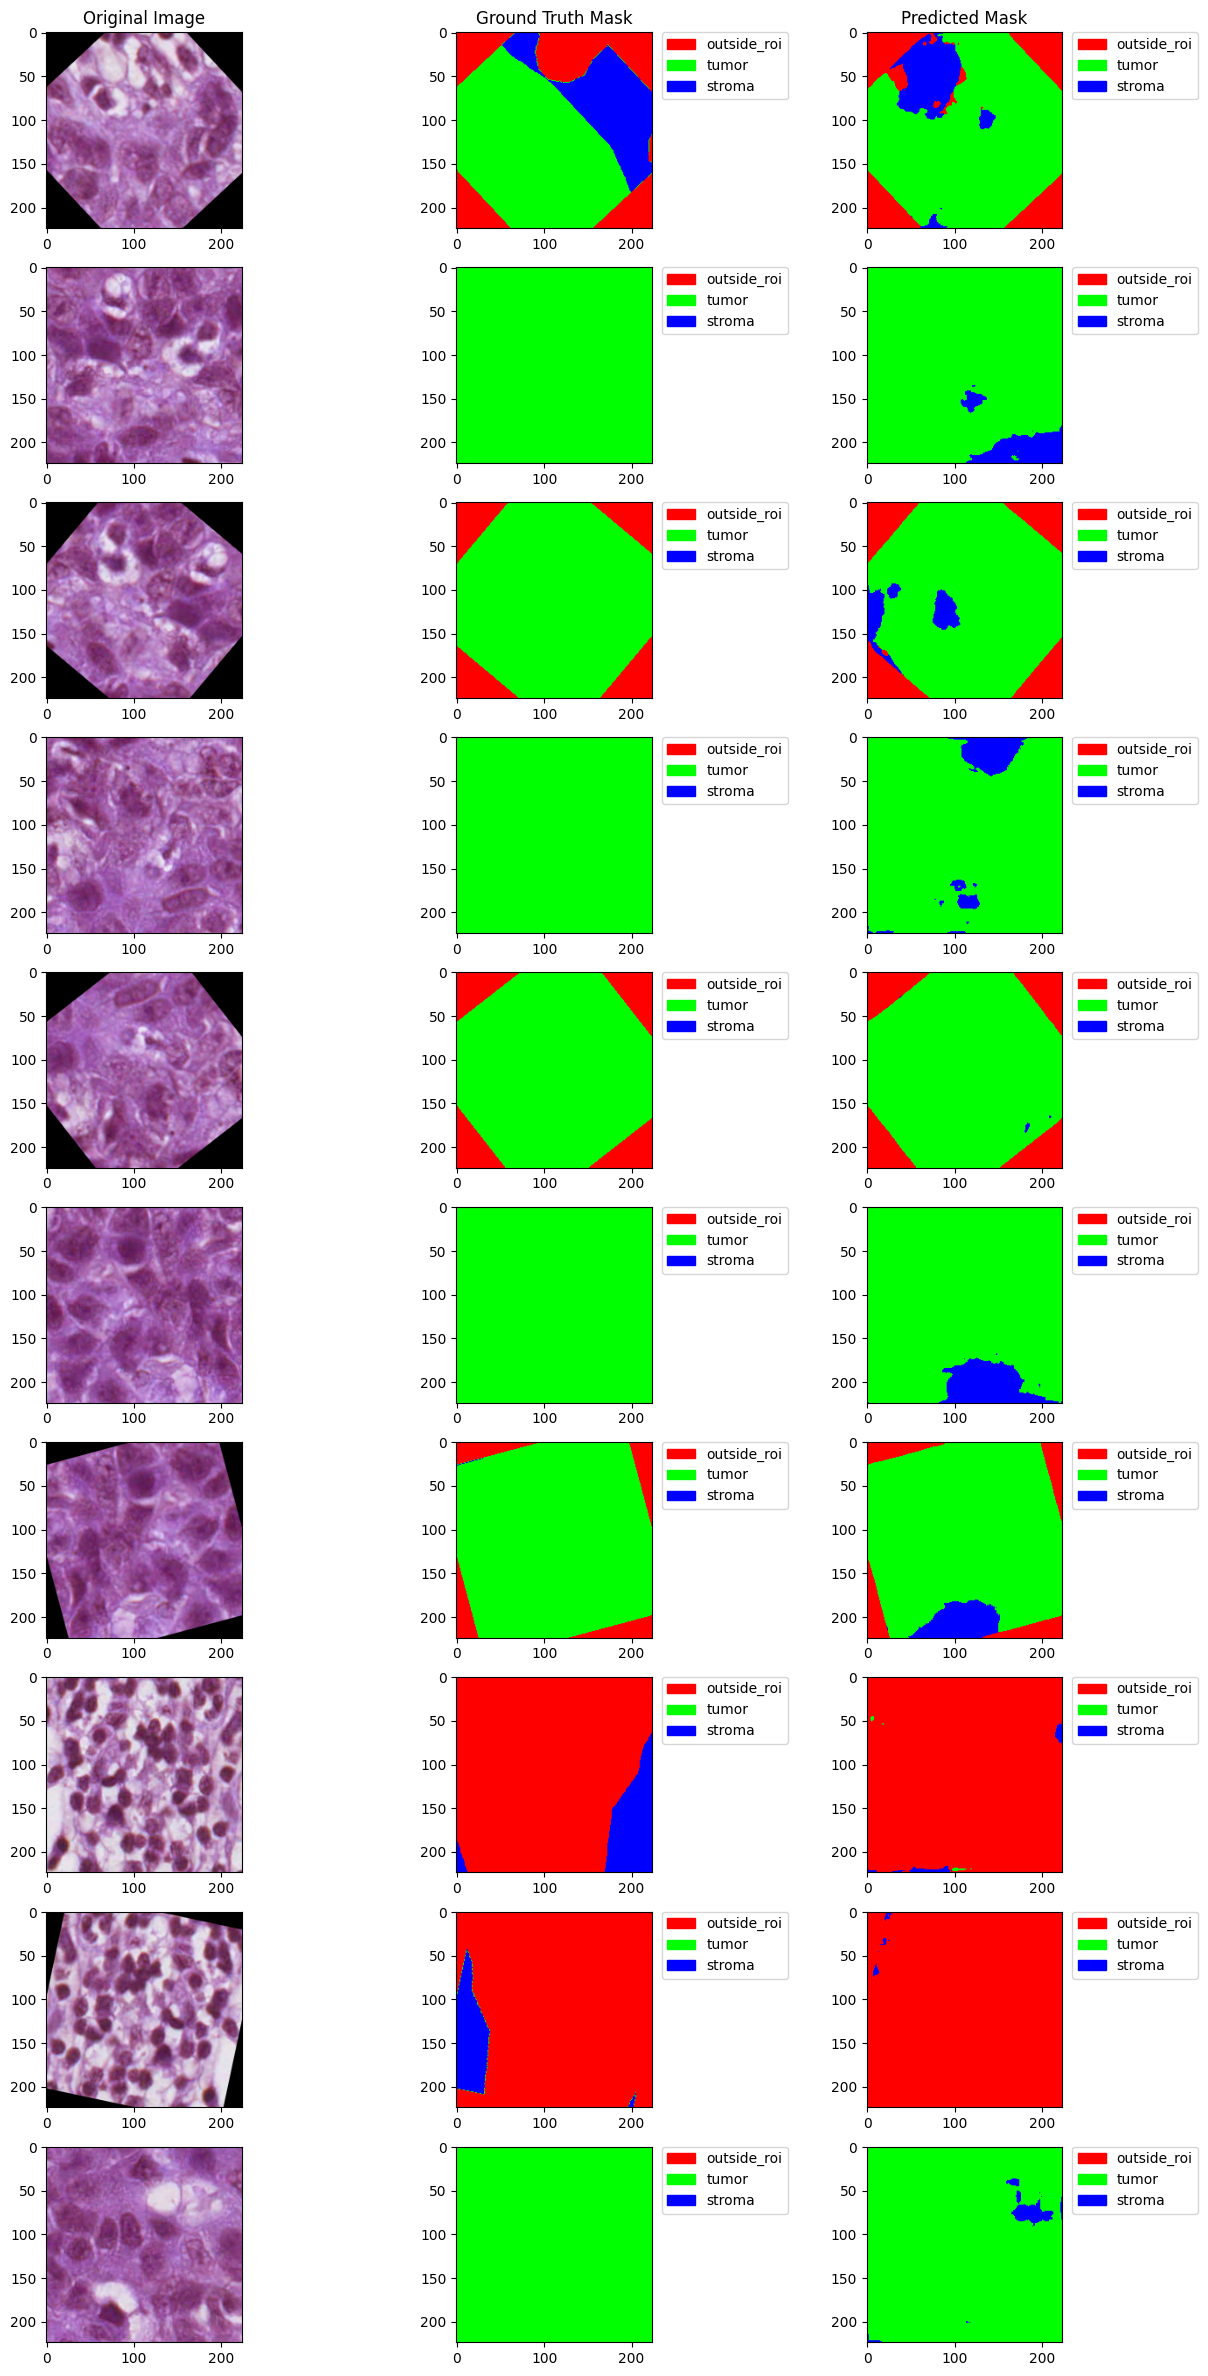

In [49]:
PlotPredictions(val_images[265:275],val_masks[265:275],mask_output,class_dict)